#Params

In [1]:
DATA_SOURCE: str = "https://raw.githubusercontent.com/h4438/data/master/demo/PrepareData_V2_2.csv"
PREDICT_COLUMN: str = 'open'
TEST_SIZE: float = .35
VALI_TO_TRAIN_SIZE: float = .35
HISTORY_RANGE: int = 60
PREDICT_RANGE: int = 14
CORRELATION_LIMIT: float = .8
RANDOM_SEED: int = 123

# Import

In [2]:
import tensorflow as tf
import math
import time
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score,cross_val_predict
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


<ipython-input-2-41a938e7fa89>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


##Util functions

In [3]:
def keep_cols(DataFrame, keep_these):
    """Keep only the columns [keep_these] in a DataFrame, delete
    all other columns."""
    drop_these = list(set(list(DataFrame)) - set(keep_these))
    return DataFrame.drop(drop_these, axis = 1)

def get_col_idx(df, col):
  return list(df.columns).index(col)

def overview_data(data):
  print(data.head(1))
  print('\n---> Data size:',data.shape)
  print('\n---> Unique values\n',data.nunique().sort_values(ascending=False))
  print('\n---> Missing values\n',data.isnull().sum().sort_values(ascending=False))
  print('\n---> Data types\n',data.info())
  return

def fix_date_format(df):
  idx = get_col_idx(df, 'tradingDate')
  for i in range(len(df['tradingDate'])):
    date = df['tradingDate'][i].split("T")[0]
    df['tradingDate'][i] = date
  return df


## Visualize functions

In [4]:
def visualize_weeks_test(dates, series_real, series_pred, raw, steps, scaler):
  alldata = []
  titles = []
  if raw is not None: 
    alldata = [raw]
    titles = ['raw']
  # real
  start = -series_real.shape[0]
  plt_dates = dates[start:]
  test_in_real = scaler.inverse_transform(series_real)
  test_week = [plt_dates, test_in_real]
  alldata.append(test_week)
  titles.append('test_real')
  # predict
  test_49ds_pred = scaler.inverse_transform(test_pred_49ds)
  prediction = [data['tradingDate'][(start+steps):], test_49ds_pred]
  alldata.append(prediction)
  titles.append('test_pred')
  plot_month_year_many(alldata,titles, "Test Open",plt_size = (20, 15))
  return

def plot_month_year(dates, values, plt_title, m_interval = 5, plt_size = (20, 5)):
  fig, ax = plt.subplots(figsize = plt_size)
  dates = dates.astype("datetime64")
  half_year_locator = mdates.MonthLocator(interval = m_interval)
  year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
  ax.xaxis.set_major_locator(half_year_locator)
  ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
  ax.set_title(f"{plt_title} in time series")
  ax.plot(dates, values)
  return

def plot_month_year_two(real, pred, plt_title, m_interval = 5, plt_size = (20, 5)):
  data1 = real
  data2 = pred
  fig, ax = plt.subplots(figsize = plt_size)
  dates1 = data1[0].astype("datetime64")
  dates2 = data2[0].astype("datetime64")
  half_year_locator = mdates.MonthLocator(interval = m_interval)
  year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
  ax.xaxis.set_major_locator(half_year_locator)
  ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
  ax.set_title(f"{plt_title} in time series")
  ax.plot(dates1, data1[1], color = 'r', label='real')
  ax.plot(dates2, data2[1], color = 'g', label='predict')
  ax.legend(['real', 'predict'], loc='upper right')
  return

def plot_month_year_many(data, labels, plt_title, m_interval = 5, plt_size = (25, 15)):
  fig, ax = plt.subplots(figsize = plt_size)
  half_year_locator = mdates.MonthLocator(interval = m_interval)
  year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
  ax.xaxis.set_major_locator(half_year_locator)
  ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
  ax.set_title(f"{plt_title} in time series")
  index = 0
  for sample in data:
    dates = sample[0].astype("datetime64")
    data_value = sample[1]
    ax.plot(dates, data_value,label=labels[index])
  # ax.plot(dates1, data1[1], color = 'r', label='real')
  # ax.plot(dates2, data2[1], color = 'g', label='predict')
  ax.legend(labels, loc='upper right')
  return

def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
  return


## Time-series functions

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = math.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

def sum_series(data, func = lambda a,b: min(a,b)):
  steps = len(data[0])
  res = [None]*steps
  start = 0
  for row in data:
    for i in range(len(row)):
      if res[start + i] == None: res[start + i] = row[i]
      else: res[start + i] = func(res[start + i], row[i])
    start += 1
    res.append(None)
  res.pop()
  res = np.array(res).reshape(-1,1)
  return res

def high_spearman_select(dataset, target_col, threshold):
  col_corr = {}
  corr_mat = dataset.corr(method = 'spearman')
  for i in range(len(corr_mat.columns)):
    #iterate column
    if abs(corr_mat.iloc[target_col,i]) < threshold:
      continue
    pairs = [corr_mat.columns[i],corr_mat.columns[target_col]]
    col_corr[corr_mat.columns[i]] = abs(corr_mat.iloc[target_col,i])
    # print(pairs)
  return col_corr


def scale_minmax_solely(data, ignore):
  # dataframe as input
  dict_scalers = {}
  cols = list(data.columns)
  scaled_data = data.copy()
  for i in cols:
    if i in ignore: continue
    scaler = MinMaxScaler()
    a = np.array(scaled_data[i]).reshape(-1, 1)
    scaled_data[i] = scaler.fit_transform(a)
    dict_scalers[i] = scaler
  return scaled_data, dict_scalers

def to_supervised(timeData, target_index, steps = 60, ahead = 1):
  # timeData is numpy
  history = []
  future = []
  start = 0
  for i in range(steps, len(timeData) - ahead+1 ):
    # history_block = [timeData[a, :].reshape(1,-1) for a in range(start, i)]
    ar_tmp = []
    for a in range(start, i):
      tmp = timeData[a,:]
      ar_tmp.append(tmp)
    history.append(ar_tmp)
    # target
    future_block = [timeData[i+j][target_index] for j in range(ahead)]
    future_block = np.array(future_block)
    future.append(future_block)
    start += 1
  x = np.array(history)
  y = np.array(future)
  return x, y



# Time-series Data

In [6]:
data = pd.read_csv(DATA_SOURCE)

## Fix and sort time

In [7]:
data = fix_date_format(data)
data.sort_values(by=['tradingDate'], ascending=True)
dates = np.unique(data['tradingDate'])
print(f'\nAll {len(dates)} dates compared  to {data.shape} datasize')

<ipython-input-3-5e47ad227e54>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradingDate'][i] = date



All 1746 dates compared  to (1746, 174) datasize


In [8]:
overview_data(data)

     open    high     low   close  volume tradingDate  month  year  quarter_y  \
0  4015.0  3993.0  3941.0  3989.0   55888  2015-01-05      1  2015          1   

  ticker  ...  loanOnAsset_x_0.701  cancelDebt_x_0.001  cancelDebt_x_0.002  \
0    ACB  ...                    0                   0                   0   

   cancelDebt_x_0.006  cancelDebt_x_0.007  cancelDebt_x_0.014  \
0                   0                   1                   0   

   badDebtOnAsset_x_0.004  badDebtOnAsset_x_0.005  badDebtOnAsset_x_0.006  \
0                       0                       0                       0   

   badDebtOnAsset_x_0.009  
0                       1  

[1 rows x 174 columns]

---> Data size: (1746, 174)

---> Unique values
 volume                    1746
tradingDate               1746
high                      1277
low                       1261
close                      645
                          ... 
capital_x_16627              2
capital_x_10273              2
capital_x_9377  

## Scaling

In [9]:
scaled_data, dict_scalers = scale_minmax_solely(data,['tradingDate', 'ticker'])
print('Scalers\n',dict_scalers)

Scalers
 {'open': MinMaxScaler(), 'high': MinMaxScaler(), 'low': MinMaxScaler(), 'close': MinMaxScaler(), 'volume': MinMaxScaler(), 'month': MinMaxScaler(), 'year': MinMaxScaler(), 'quarter_y': MinMaxScaler(), 'fixedAsset_x': MinMaxScaler(), 'asset_x': MinMaxScaler(), 'debt_x': MinMaxScaler(), 'equity_x': MinMaxScaler(), 'capital_x': MinMaxScaler(), 'customerLoan_x': MinMaxScaler(), 'badLoan_x': MinMaxScaler(), 'provision_x': MinMaxScaler(), 'netCustomerLoan_x': MinMaxScaler(), 'otherAsset_x': MinMaxScaler(), 'otherBankCredit_x': MinMaxScaler(), 'oweOtherBank_x': MinMaxScaler(), 'valuablePaper_x': MinMaxScaler(), 'payableInterest_x': MinMaxScaler(), 'receivableInterest_x': MinMaxScaler(), 'deposit_x': MinMaxScaler(), 'otherDebt_x': MinMaxScaler(), 'fund_x': MinMaxScaler(), 'unDistributedIncome_x': MinMaxScaler(), 'payable_x': MinMaxScaler(), 'cash_y': MinMaxScaler(), 'fixedAsset_y': MinMaxScaler(), 'asset_y': MinMaxScaler(), 'debt_y': MinMaxScaler(), 'equity_y': MinMaxScaler(), 'capita

In [10]:
scaled_data.describe()

,open,high,low,close,volume,month,year,quarter_y,fixedAsset_x,asset_x,...,loanOnAsset_x_0.701,cancelDebt_x_0.001,cancelDebt_x_0.002,cancelDebt_x_0.006,cancelDebt_x_0.007,cancelDebt_x_0.014,badDebtOnAsset_x_0.004,badDebtOnAsset_x_0.005,badDebtOnAsset_x_0.006,badDebtOnAsset_x_0.009
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,...,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,0.280381,0.283988,0.288673,0.280427,0.090861,0.513121,0.499809,0.515082,0.605907,0.435115,...,0.284651,0.429553,0.141466,0.143757,0.142039,0.143184,0.284651,0.429553,0.143757,0.142039
std,0.242853,0.244624,0.250913,0.243403,0.107960,0.310054,0.333190,0.370594,0.369553,0.331078,...,0.451377,0.495154,0.348602,0.350944,0.349190,0.350361,0.451377,0.495154,0.350944,0.349190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062148,0.063425,0.063524,0.061317,0.013892,0.272727,0.166667,0.333333,0.284728,0.098752,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.264932,0.266703,0.273821,0.265026,0.054161,0.545455,0.500000,0.666667,0.577897,0.391881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.337103,0.338964,0.345840,0.335662,0.128500,0.818182,0.833333,1.000000,0.990023,0.744907,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualize the data

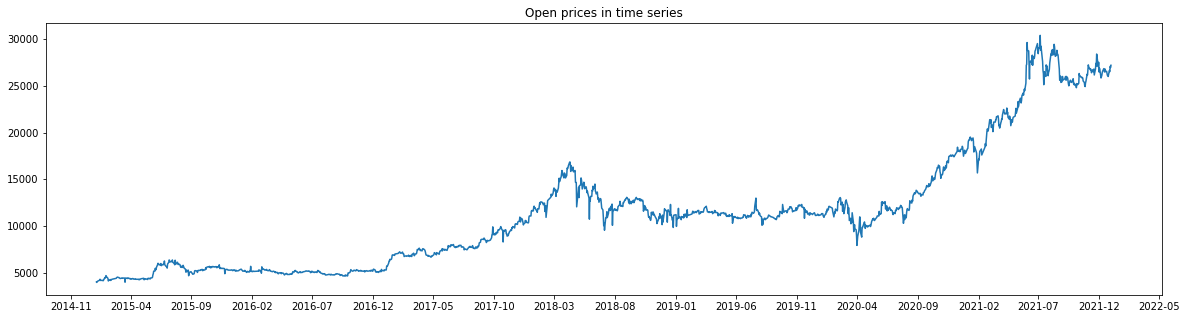

In [11]:
plot_month_year(data['tradingDate'], data['open'], "Open prices")

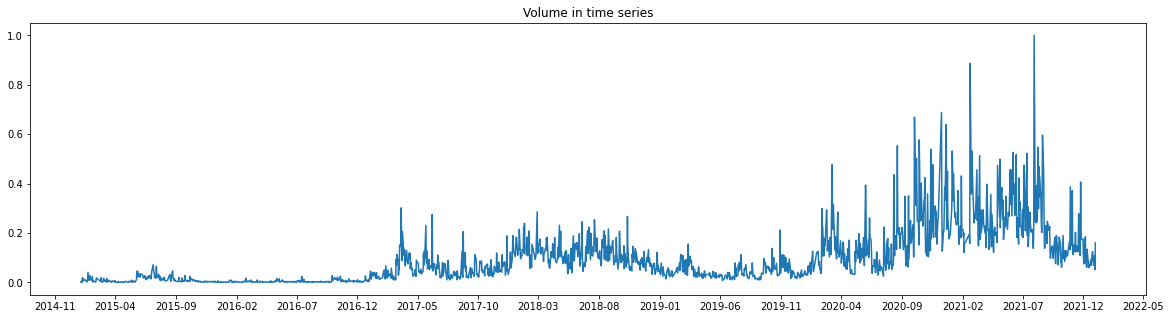

In [12]:
plot_month_year(data['tradingDate'], scaled_data['volume'], 'Volume')

## Drop & scale

In [13]:
dropped = ['ticker', 'tradingDate', 'month', 'year']
scaled_np = scaled_data.drop(dropped, axis = 1)
print("Before scaling:", data.shape)
print("After scaling:", scaled_np.shape)
print(f'Scale df type: {type(scaled_np)}, size {scaled_np.shape}')
scaled_data_np = np.array(scaled_np)
print(f'Scale np type: {type(scaled_np)}, size {scaled_np.shape}')

Before scaling: (1746, 174)
After scaling: (1746, 170)
Scale df type: <class 'pandas.core.frame.DataFrame'>, size (1746, 170)
Scale np type: <class 'pandas.core.frame.DataFrame'>, size (1746, 170)


In [14]:
col_open = get_col_idx(data,PREDICT_COLUMN)

##Spearman feat select

In [15]:
corel = high_spearman_select(data,col_open, CORRELATION_LIMIT)
print(corel)
print(len(corel))
# choose only the top rank correlated features
choose = [k for k,v in corel.items() if v >= .85]
select_data = keep_cols(scaled_data, choose)
select_data.drop(['year'], axis = 1, inplace=True)
select_col_open = get_col_idx(select_data, PREDICT_COLUMN)
print('Col_open:',select_col_open)
print(select_data.head(2))

{'open': 1.0, 'high': 0.9962206727338297, 'low': 0.996710532487689, 'close': 0.9954252464874925, 'volume': 0.8542517783550349, 'year': 0.8920662548849156, 'asset_x': 0.8920662548849156, 'debt_x': 0.8920662548849156, 'equity_x': 0.8920662548849156, 'capital_x': 0.9020087247879591, 'customerLoan_x': 0.8920662548849156, 'provision_x': 0.9220566464498053, 'netCustomerLoan_x': 0.8920662548849156, 'otherBankCredit_x': 0.9062560645631765, 'oweOtherBank_x': 0.8705100291895902, 'valuablePaper_x': 0.8920662548849156, 'payableInterest_x': 0.8283274504943314, 'deposit_x': 0.8920662548849156, 'otherDebt_x': 0.8920662548849156, 'fund_x': 0.8920662548849156, 'unDistributedIncome_x': 0.8920662548849156, 'payable_x': 0.8920662548849156, 'cash_y': 0.86893763955565, 'asset_y': 0.8965720083303722, 'debt_y': 0.8965720083303722, 'equity_y': 0.8927055607338064, 'capital_y': 0.8919367197293384, 'otherBankDeposit': 0.8123077552020194, 'stockInvest': 0.813984220185438, 'customerLoan_y': 0.8979276144700533, 'net

##Split

In [16]:
select_np = np.array(select_data)
train,test = train_test_split(select_np, test_size = TEST_SIZE, shuffle=False)
train, validate = train_test_split(train, test_size = VALI_TO_TRAIN_SIZE, shuffle = False)
print('Train size:',train.shape)
print('Test size:',test.shape)
print('Validate size:',validate.shape)

Train size: (737, 57)
Test size: (612, 57)
Validate size: (397, 57)


##Test split

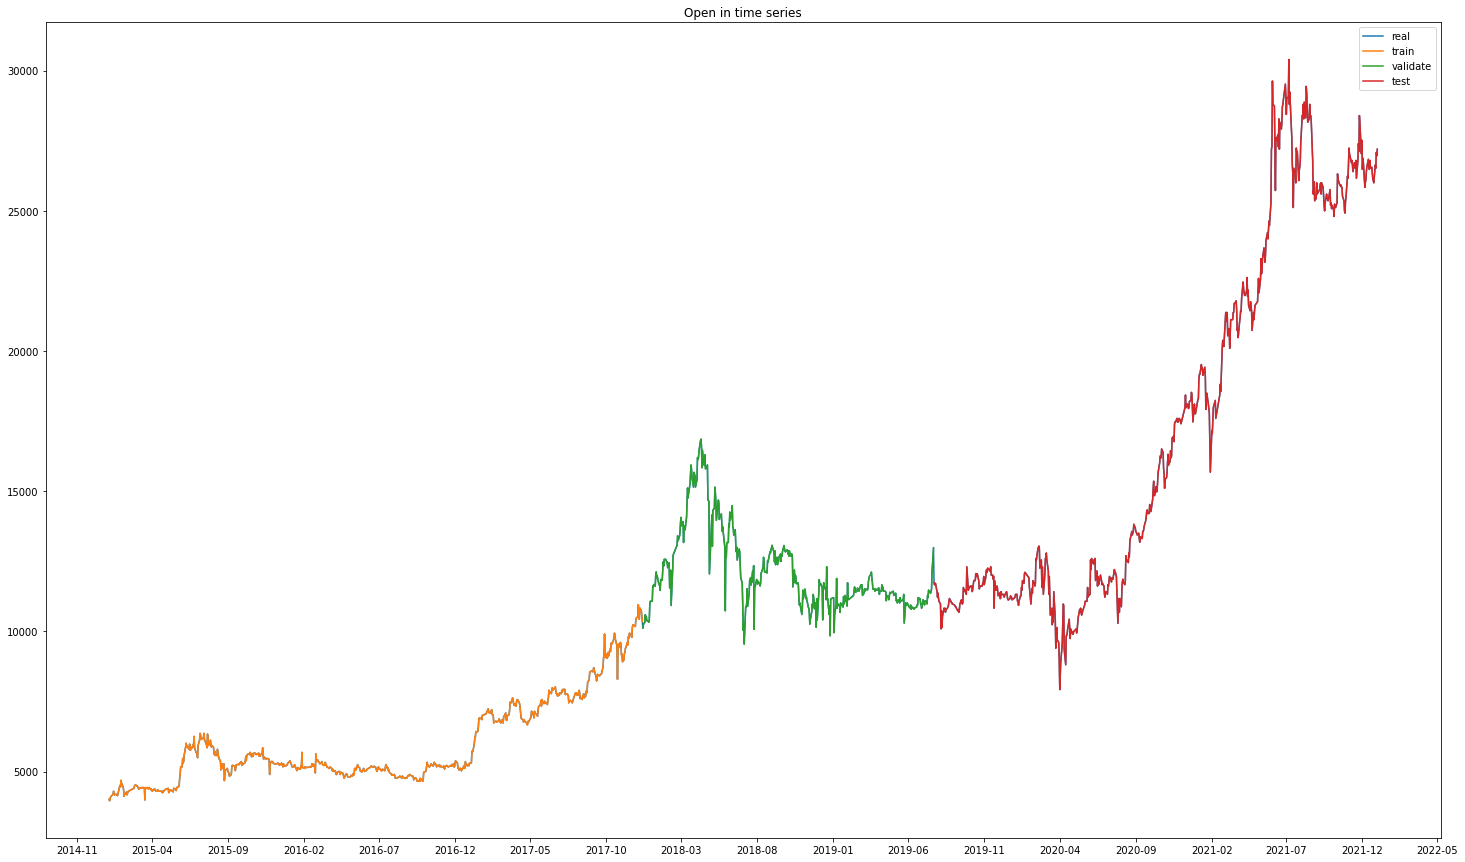

In [17]:
train_rows = train.shape[0]
data1 = [data['tradingDate'], data['open']]
train_in_real = train.copy()
scaler = dict_scalers.get('open')
# train
train_in_real = scaler.inverse_transform(train_in_real)
data2 = [data['tradingDate'][:train_rows], train_in_real[:,col_open]]
# validate
vali_rows = validate.shape[0]
start, end = train_rows, train_rows+vali_rows
vali_in_real = validate.copy()
vali_in_real = scaler.inverse_transform(vali_in_real)
data3 = [data['tradingDate'][start:end], vali_in_real[:,col_open]]
# test
train_rows = train.shape[0]
vali_rows = validate.shape[0]
test_rows = train_rows+vali_rows
test_in_real = test.copy()
test_in_real = scaler.inverse_transform(test_in_real)
data4 = [data['tradingDate'][test_rows:], test_in_real[:,col_open]]
alldata = [data1,data2,data3,data4]
plot_month_year_many(alldata,['real','train','validate','test'], "Open")

#Train LSTM 14 days

In [24]:
train_x, train_y = to_supervised(train, col_open, HISTORY_RANGE, PREDICT_RANGE)
vali_x, vali_y = to_supervised(validate, col_open, HISTORY_RANGE, PREDICT_RANGE)
test_x, test_y = to_supervised(test, col_open, HISTORY_RANGE, PREDICT_RANGE)
print(f'Train; X size: {train_x.shape}; y size: {train_y.shape}')
print(f'Validate; X size: {vali_x.shape}; y size: {vali_y.shape}')
print(f'Test; X size: {test_x.shape}; y size: {test_y.shape}')

Train; X size: (664, 60, 57); y size: (664, 14)
Validate; X size: (324, 60, 57); y size: (324, 14)
Test; X size: (539, 60, 57); y size: (539, 14)


##Build model

In [ ]:
history_size = HISTORY_RANGE
n_feat = train.shape[1]
input_size = (history_size, n_feat)
print("--> Input size:",input_size)
model = Sequential()
model.add(LSTM(units = 256, activation="relu", input_shape = input_size) )
model.add(Dense(14))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()
filepath="weights14days.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

--> Input size: (60, 57)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               321536    
                                                                 
 dense_6 (Dense)             (None, 14)                3598      
                                                                 
Total params: 325,134
Trainable params: 325,134
Non-trainable params: 0
_________________________________________________________________


In [ ]:
steps = train_x.shape[0]
start_time = time.time()
history =  model.fit(train_x, train_y, steps_per_epoch=steps, epochs=40, 
                     validation_data = (vali_x, vali_y), callbacks=callbacks_list)
end_time = time.time()

Epoch 1/40
663/664 [============================>.] - ETA: 0s - loss: 9.2332e-05
Epoch 1: val_loss did not improve from 0.00277
664/664 [==============================] - 38s 55ms/step - loss: 9.2216e-05 - val_loss: 0.0032
Epoch 2/40
663/664 [============================>.] - ETA: 0s - loss: 9.2543e-05
Epoch 2: val_loss improved from 0.00277 to 0.00257, saving model to weights14days.best.hdf5
664/664 [==============================] - 36s 55ms/step - loss: 9.2744e-05 - val_loss: 0.0026
Epoch 3/40
664/664 [==============================] - ETA: 0s - loss: 9.3121e-05
Epoch 3: val_loss improved from 0.00257 to 0.00187, saving model to weights14days.best.hdf5
664/664 [==============================] - 36s 54ms/step - loss: 9.3121e-05 - val_loss: 0.0019
Epoch 4/40
664/664 [==============================] - ETA: 0s - loss: 9.3379e-05
Epoch 4: val_loss did not improve from 0.00187
664/664 [==============================] - 36s 54ms/step - loss: 9.3379e-05 - val_loss: 0.0040
Epoch 5/40
664/664

## Evaluation

In [ ]:
a = end_time - start_time
print(f"Total training time: {a/60} minutes")

Total training time: 24.45438377459844 minutes


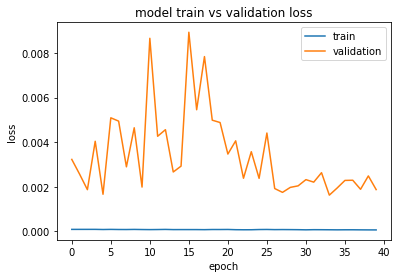

In [ ]:
plot_history(history)

In [ ]:
print(test_x.shape)
pred = model.predict(test_x, steps = test_x.shape[0])
pred_train = model.predict(train_x, steps = train_x.shape[0])
pred_vali = model.predict(vali_x, steps = vali_x.shape[0])

(539, 60, 57)
324/324 [==============================] - 4s 12ms/step


In [ ]:
print(f'Test size {pred.shape} vs {test_y.shape}')
print(f'Train size {pred_train.shape} vs {train_y.shape}')
print(f'Validate size {pred_vali.shape} vs {vali_y.shape}')

Test size (539, 14) vs (539, 14)
Train size (664, 14) vs (664, 14)
Validate size (324, 14) vs (324, 14)


## Visualize

612
552


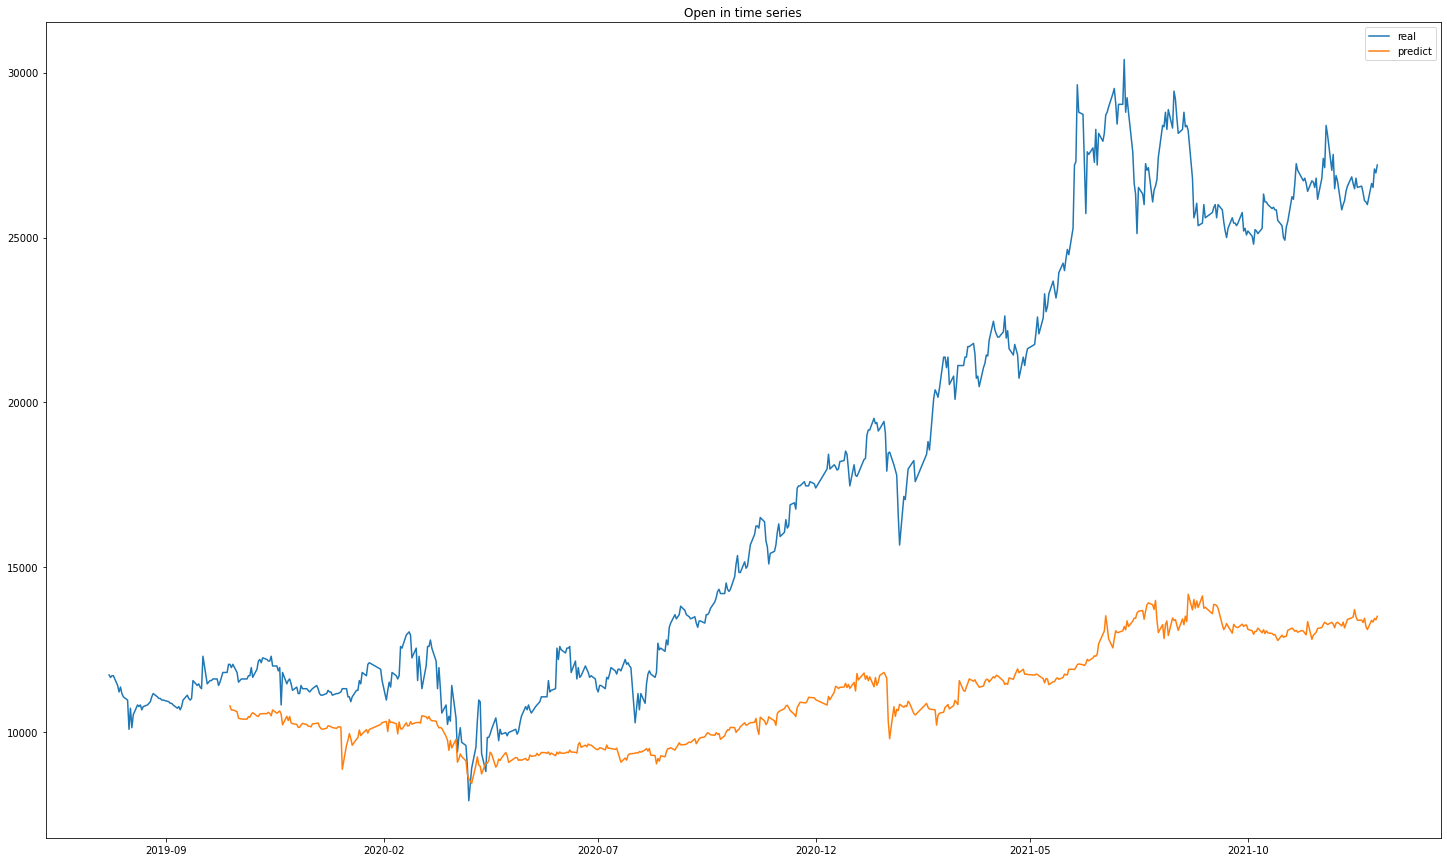

In [ ]:
test_size = len(test)
print(test_size)
# real
test_rows = train.shape[0]+validate.shape[0]
test_in_real = test.copy()
test_in_real = scaler.inverse_transform(test_in_real)
test_week = [data['tradingDate'][test_rows:], test_in_real[:,col_open]]
test_pred = sum_series(pred)
# test_real = sum_series(test_y, lambda x,y: x if x==y else -1)
print(len(test_pred))
# print(len(test_real))
test_pred = scaler.inverse_transform(test_pred)
prediction = [data['tradingDate'][(test_rows+60):], test_pred]
alldata = [test_week,prediction] 
plot_month_year_many(alldata,['real','predict'], "Open")

## Load best model

In [ ]:
model.load_weights("weights14days.best.hdf5")
model.compile(loss='mean_squared_error', optimizer = 'adam')
print("Created model and loaded weights from file")
scores = model.evaluate(test_x, test_y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names, scores*100))

Created model and loaded weights from file
['loss']: 1.52%


In [ ]:
print(test_x.shape)
pred_14d = model.predict(test_x, steps = test_x.shape[0])
pred_train_14d = model.predict(train_x, steps = train_x.shape[0])
pred_vali_14d = model.predict(vali_x, steps = vali_x.shape[0])

(539, 60, 57)
324/324 [==============================] - 4s 12ms/step


## Visualize best model

612
552


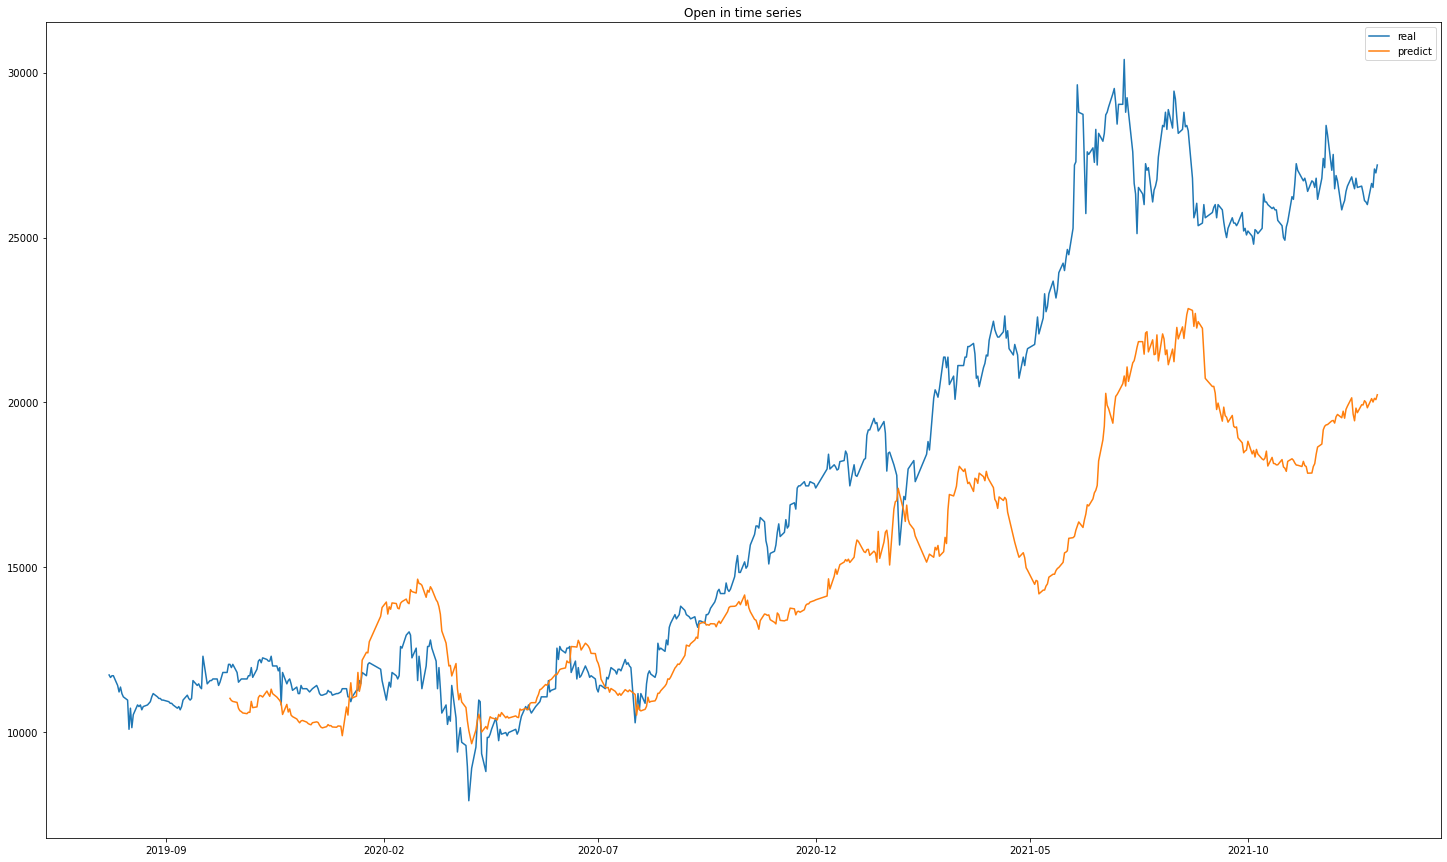

In [ ]:
test_size = len(test)
print(test_size)
# real
test_rows = train.shape[0]+validate.shape[0]
test_in_real = test.copy()
test_in_real = scaler.inverse_transform(test_in_real)
test_week = [data['tradingDate'][test_rows:], test_in_real[:,select_col_open]]
test_pred = sum_series(pred_14d)
print(len(test_pred))
# print(len(test_real))
test_pred = scaler.inverse_transform(test_pred)
prediction = [data['tradingDate'][(test_rows+60):], test_pred]
alldata = [test_week,prediction] 
plot_month_year_many(alldata,['real','predict'], "Open")

#Adjust price with news

In [18]:
select_data.describe()

,open,high,low,close,volume,asset_x,debt_x,equity_x,capital_x,customerLoan_x,...,interestMargin_x,provisionOnBadDebt_x,costToIncome_x,preProvisionOnToi_x,loanOnDeposit_x,depositOnEarnAsset_x,roa_y,earningPerShare_y,bookValuePerShare_y,interestMargin_y
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,...,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,0.280381,0.283988,0.288673,0.280427,0.090861,0.435115,0.442588,0.366650,0.335919,0.455306,...,0.326297,0.506618,0.541912,0.466434,0.421365,0.621246,0.435651,0.415609,0.351318,0.411846
std,0.242853,0.244624,0.250913,0.243403,0.107960,0.331078,0.329705,0.348564,0.358771,0.331126,...,0.330560,0.294115,0.327998,0.327259,0.316252,0.322775,0.362145,0.350969,0.305519,0.242765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062148,0.063425,0.063524,0.061317,0.013892,0.098752,0.105197,0.039704,0.000000,0.123819,...,0.000000,0.322712,0.238255,0.106557,0.083799,0.433155,0.058824,0.054984,0.072992,0.250000
50%,0.264932,0.266703,0.273821,0.265026,0.054161,0.391881,0.406683,0.256283,0.198900,0.420096,...,0.285714,0.530229,0.560403,0.450820,0.446927,0.631016,0.588235,0.499604,0.304343,0.416667
75%,0.337103,0.338964,0.345840,0.335662,0.128500,0.744907,0.749194,0.705633,0.693742,0.777397,...,0.571429,0.718954,0.906040,0.770492,0.603352,0.951872,0.705882,0.712025,0.593446,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
dates = data['tradingDate']
ticker = data['ticker']
print(len(dates),'days')
print(dates[0],'to',dates[1745])
print(ticker[0])

1746 days
2015-01-05 to 2021-12-31
ACB


In [20]:
from datetime import datetime
from datetime import timedelta

end_date = dates[1745]
date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
print(type(date_object))
print(date_object)

future = [date_object+timedelta(days=i) for i in range(1,15)]


<class 'datetime.date'>
2021-12-31


## 1-1 to 14-1

In [21]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [22]:
import pickle
modelPath = "gdrive/MyDrive/models/lstm_14d_model_pkl"
with open(modelPath , 'rb') as f:
    lstm = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-02-19 07:19:58      1318624
config.json                                    2023-02-19 07:19:58         1808
metadata.json                                  2023-02-19 07:19:58           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
...vars


In [25]:
pred = lstm.predict(test_x, steps = test_x.shape[0])

539/539 [==============================] - 7s 13ms/step


In [27]:
pred14 = scaler.inverse_transform(pred[-1].reshape(1,-1))[0]
print(pred14)
print(len(pred14))

[34182.69  30118.379 29759.16  33182.33  35472.3   23419.416 30571.676
 26878.533 29543.906 23689.059 26661.307 25765.828 26612.934 28517.467]
14


In [28]:
prices14d = [[str(i),p] for i,p in zip(future,pred14)]
for i in prices14d:
  print(i)

['2022-01-01', 34182.69]
['2022-01-02', 30118.379]
['2022-01-03', 29759.16]
['2022-01-04', 33182.33]
['2022-01-05', 35472.3]
['2022-01-06', 23419.416]
['2022-01-07', 30571.676]
['2022-01-08', 26878.533]
['2022-01-09', 29543.906]
['2022-01-10', 23689.059]
['2022-01-11', 26661.307]
['2022-01-12', 25765.828]
['2022-01-13', 26612.934]
['2022-01-14', 28517.467]
